# CSE488 Project

I want you to pretend you are competing in http://celltrackingchallenge.net/.  Unfortunately, we missed the ISBI2024 deadline but practicing on a realistic challenges is good practice. There may be a 2025 challenge…..


**NOTE:** I am sharing this on colab, but you will likely want to run jupyter locally to do this project.  Colab will kick you out and you will lose your data after a few hours unless you pay them.

# Data and Starter Code

The goal of this project is to successfully segment cell images.

You will use the evaluation programs provided by the challenge creators to evaluate your results.  The cells below will download the testing program.

In [128]:
# Initial cell (automatically executed)
try:
  import imagecodecs   # Needed to open compressed tif files
except:
  %pip install imagecodecs  # Needed to open compressed tif files

import os
from IPython.display import clear_output
clear_output()

In order for data to persist on Google colab, I have this set up to link to your Google Drive account.   
You may instead wish to work locally, which would inolve installing Jupyter instead.  [Instructions are here](https://test-jupyter.readthedocs.io/en/latest/install.html).   

The next cell should only be executed if you are using colab:

In [129]:
# Mount Google Drive (a popup window will show)
try:
  from google.colab import drive
  drive.mount('/gdrive')

  # Create a project folder if it does nto already exist, and SymLink to it.
  BASE_PATH='/gdrive/MyDrive/CSE488/Project'
  !mkdir -p {BASE_PATH}
  !ln -s {BASE_PATH}

except ModuleNotFoundError:
  print("You appear to be running things locally, please set the BASE_PATH accordingly")
  BASE_PATH="/home/sid/Drive_D/COLLEGE_MATERIALS/SOPHOMORE_2/CSE488/Cell-Tracking-Segmentation"

You appear to be running things locally, please set the BASE_PATH accordingly


This project is based on an official comptetition.   
The competition comes with (C++) code to evaluate your cell segmentation results uing the Jaccard index (intersection over union).  
The next cell downloads their code.  

**NOTE**: The cell assumes you are using Linux.

In [130]:
# Download the official evaluation software and uncompress it.
if not os.path.exists(f'{BASE_PATH}/Linux/SEGMeasure'):
  !wget http://public.celltrackingchallenge.net/software/EvaluationSoftware.zip -O {BASE_PATH}/EvaluationSoftware.zip
  !unzip {BASE_PATH}/EvaluationSoftware.zip -d {BASE_PATH}
  clear_output()

# Make SEGMeasure executable
import sys
if sys.platform != 'linux':
  print("You need to put the right version SEGMeasure in your path and make sure it is executable.")
else: # linux
  os.environ['PATH'] = f'{BASE_PATH}/Linux' + os.pathsep + os.environ['PATH']
  !chmod a+x {BASE_PATH}/Linux/SEGMeasure


The input images come with associated ground-truth files.  
The names of the files are important (note the pattern [described here](https://public.celltrackingchallenge.net/documents/Naming%20and%20file%20content%20conventions.pdf))

Essentially:   
 -  The data is a set of videos. The file name starts with the video (e.g. 01)
 -  The labels are either manual "gold" truth  (01_GT)
 -  Or they are the consensus of automatic methods, "silver" truth (01_ST)
 -  The input files have named like `t001.tif` for which is the input at time 1.
 -  The target files for the semantic segmentation task (our chellenge) are named like `SEG/man_seg001.tif`.
 -  Your predictions will be in a folder like `01_RES` with a name like `mask001.tif`.

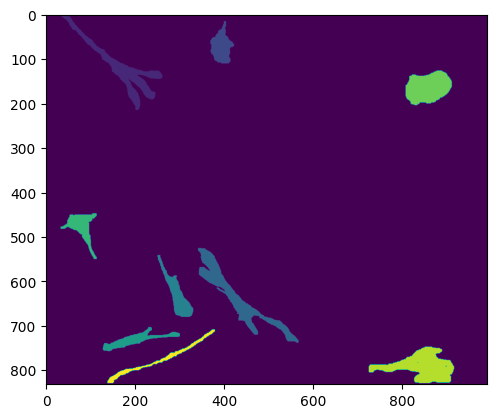

In [131]:
from skimage import io
from matplotlib.pylab import plt

gt = io.imread('./testing_dataset/01_GT/SEG/man_seg005.tif')
plt.imshow(gt);

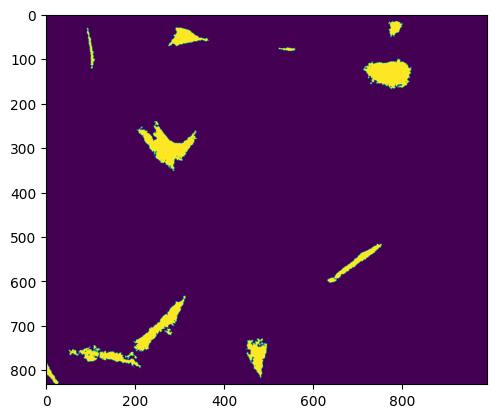

In [132]:
result = io.imread('./testing_dataset/01_RES/mask045.tif')
plt.imshow(result>0)

The segmentation accuracy for this contest is based on:
1.   Matching a result with one of the GT objects (overlap > 50%)
2.   Computing the Intersection-over-Union (IoU) of the objects.

The IoU is also called the Jaccard index.  
To help you with debugging things and to make things clear, I have a python version of the evaluation code below:

In [133]:
import numpy as np
from skimage.measure import label, regionprops
from scipy.optimize import linear_sum_assignment

def compute_jaccard_index_for_matches(ref_image, seg_mask):
    # Label connected components in the binary segmentation mask
    labeled_mask = label(seg_mask)
    # Extract properties of labeled regions
    mask_props = regionprops(labeled_mask)

    jaccard_indices = {}

    # Iterate over each unique object label in the reference image
    for ref_label in np.unique(ref_image):
        if ref_label == 0:  # Skip background
            continue

        # Extract the reference object by its label
        ref_object = (ref_image == ref_label)

        # Initialize an array to hold overlaps with mask objects
        overlaps = []

        for prop in mask_props:
            # Calculate intersection and union with each segmented object
            intersection = np.sum(ref_object & (labeled_mask == prop.label))
            union = np.sum(ref_object | (labeled_mask == prop.label))

            # Check for the matching criterion and calculate Jaccard index
            if intersection > 0.5 * np.sum(ref_object):
                jaccard_index = intersection / union
                overlaps.append(jaccard_index)
            else:
                overlaps.append(0)

        # Find the best match based on the highest Jaccard index
        if overlaps:
            best_match_jaccard = max(overlaps)
            jaccard_indices[ref_label] =best_match_jaccard

    # Compute the mean Jaccard index across all matched pairs
    mean_jaccard_index = np.mean(list(jaccard_indices.values())) if jaccard_indices else 0
    return mean_jaccard_index, jaccard_indices


In [134]:
metrics = compute_jaccard_index_for_matches(gt, result)

# IoU = Jaccard index (different name, same thing)
mIoU,  per_obj_IoUs = metrics
print(f"mIoU={mIoU}")
for object_index in per_obj_IoUs:
  print(f"Best IoU for target object {object_index:>3} is {per_obj_IoUs[object_index]}")

mIoU=0.0
Best IoU for target object   1 is 0
Best IoU for target object   2 is 0
Best IoU for target object   3 is 0
Best IoU for target object   4 is 0
Best IoU for target object   5 is 0
Best IoU for target object   6 is 0
Best IoU for target object   7 is 0
Best IoU for target object   8 is 0
Best IoU for target object   9 is 0


Your goal is to process an entire test set, and evaluate it using their evaluation program (similar to the python function I included above)

In [135]:
!./Linux/SEGMeasure {BASE_PATH}/testing_dataset 01 3
print()
print("The breakdown (by file) is in a SEG_log.txt")
print()
!tail -n 20 {BASE_PATH}/testing_dataset/01_RES/SEG_log.txt

SEG measure: 0.232874

The breakdown (by file) is in a SEG_log.txt

GT_label=2 J=0.505003
----------T=45 Z=0----------
GT_label=1 J=0
GT_label=2 J=0.49626
GT_label=3 J=0
GT_label=4 J=0.588353
GT_label=5 J=0.540328
GT_label=6 J=0
GT_label=7 J=0
GT_label=8 J=0
GT_label=9 J=0
GT_label=10 J=0
----------T=46 Z=0----------
GT_label=1 J=0.610354
GT_label=2 J=0
----------T=47 Z=0----------
GT_label=1 J=0
GT_label=2 J=0
SEG measure: 0.232874


## Getting The Fluo-N2DH-GOWT1 Data Set

Several types of cell data are provided at http://celltrackingchallenge.net/2d-datasets/

For now, try to handle the mouse cells...

!mkdir -p {BASE_PATH}/training-datasets
!mkdir -p {BASE_PATH}/test-datasets

# Consider other datasets from http://celltrackingchallenge.net/2d-datasets/

if not os.path.exists('Project/training-datasets/Fluo-N2DH-GOWT1.zip'):
  !wget http://data.celltrackingchallenge.net/training-datasets/Fluo-N2DH-GOWT1.zip -O {BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1.zip
  !unzip -oq {BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1.zip -d {BASE_PATH}/training-datasets/

if not os.path.exists('Project/test-datasets/Fluo-N2DH-GOWT1.zip'):
  !wget http://data.celltrackingchallenge.net/test-datasets/Fluo-N2DH-GOWT1.zip -O {BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1.zip
  !unzip -oq {BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1.zip -d {BASE_PATH}/test-datasets/


Here is an example of one image

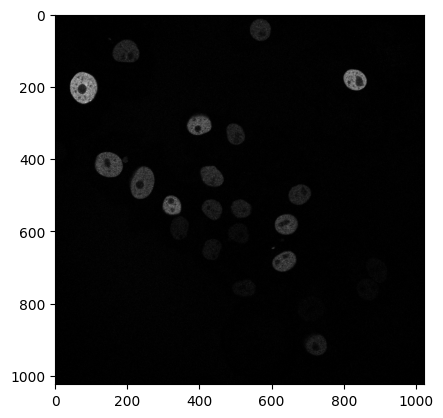

In [136]:
plt.imshow(io.imread(f'{BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1/01/t001.tif'), cmap='gray');

If you want to see the entire video, use the snippet below:

In [137]:
if not os.path.exists(f'{BASE_PATH}/Fluo-N2DH-GOWT1_01.mp4'):
  !ffmpeg -i {BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1/01/t%03d.tif  -vf "scale=iw/2:ih/2" {BASE_PATH}/Fluo-N2DH-GOWT1_01.mp4

from IPython.display import clear_output, Video
clear_output()
Video(f'{BASE_PATH}/Fluo-N2DH-GOWT1_01.mp4', embed=True, html_attributes='autoplay loop')

Not every cell was labeled in the GT folder, so you may want to use the ST folder to tune your segmentation method.

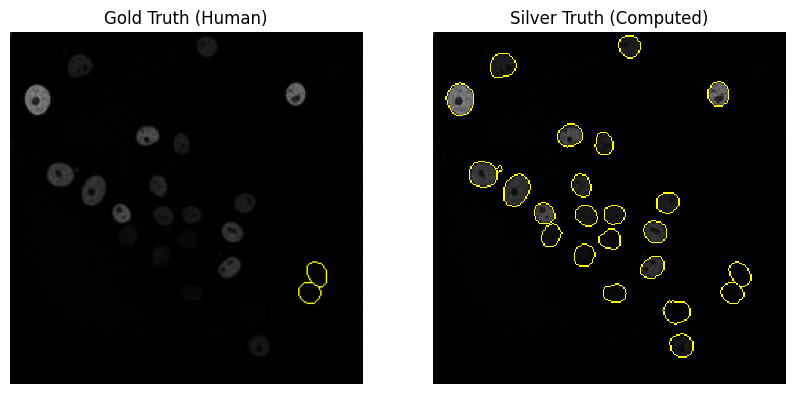

In [138]:
from skimage.segmentation import mark_boundaries
from skimage.transform import resize

plt.figure(figsize=(10,5))

# Shrinking images to make outlines clearere
input_image = io.imread(f'{BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1/01/t005.tif')
input_image = resize(input_image, (256, 256))

plt.subplot(121)
gt_segmentation = io.imread(f'{BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1/01_GT/SEG/man_seg005.tif')
gt_segmentation = resize(gt_segmentation>0.5, (256, 256), order=0, preserve_range=True)
plt.imshow(mark_boundaries(input_image, gt_segmentation))
plt.title("Gold Truth (Human)")
plt.axis('off')

plt.subplot(122)
st_segmentation = io.imread(f'{BASE_PATH}/training-datasets/Fluo-N2DH-GOWT1/01_ST/SEG/man_seg005.tif')
st_segmentation = resize(st_segmentation>0.5, (256, 256), order=0, preserve_range=True)
plt.imshow(mark_boundaries(input_image, st_segmentation), interpolation='nearest')
plt.title("Silver Truth (Computed)");
plt.axis('off');

# Goal

Your task is to try and classify the pixels in order to segment cells.

To help you out, I have a code snippet for neighborhood-based set of features to use for classifying.


You are to prepare a table comparing several methods of segmenting the cells.
1.  Use a Naive Bayesian classifier.
2.  Use logistic regression.
3.  Use a SVM (not play with different kernels)
4.  Use a neural network (on the features)
5.  Use a convnet (on the original image) either of your own design or one of the pytorch models (such as `resenet18`)

In addition, you can explore ways to preprocess the image (histogram equalization, denoising) or postprocess in order to improve results.


What I expect you to do it to generate a "RES" folder for each method,  and use `SEGMeasure` to quantify your results.   For example, create  folders
```
mkdir -p {BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1/01_RES_NAIVE_BAYES
mkdir -p {BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1/01_RES_LOG_REG
...

```
Then, to evaluate Naive Bayes:
```
ln -s {BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1/01_RES_NAIVE_BAYES {BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1/01_RES
SEGMeasure {BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1 01 3
```
and record the result.

In [148]:
!ln -s {BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1/01_N_BAYES {BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1/01_RES

In [155]:
!SEGMeasure {BASE_PATH}/test-datasets/Fluo-N2DH-GOWT1 01 3

i3d::IOException: I3D::TIFFReader: unsupported sample format.
The image '/home/sid/Drive_D/COLLEGE_MATERIALS/SOPHOMORE_2/CSE488/Cell-Tracking-Segmentation/test-datasets/Fluo-N2DH-GOWT1/01_RES/mask000.tif' cannot be opened!


# Approach

# Traditional ML: Naive Bayes & Logistic Regression & SVC

In [60]:
import os
import glob

In [61]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from skimage.morphology import dilation, disk, opening, closing, erosion
import pandas as pd

In [62]:
from skimage.util import view_as_windows

image = io.imread('./training-datasets/Fluo-N2DH-GOWT1/01/t001.tif')
height, width = image.shape
window_size=3 # Try others, like 11
image_features = view_as_windows(np.pad(image, (window_size-1)//2),  (window_size,window_size))
flat_features = image_features.reshape(height*width, window_size**2)

In [63]:
from skimage.util import view_as_windows

def getImgFeatures(image_dir, window_size):
    image = io.imread(image_dir)
    # add any sort of preprocessing in the flat features
    height, width = image.shape
    image_features = view_as_windows(np.pad(image, (window_size-1)//2),  (window_size,window_size))
    flat_features = image_features.reshape(height*width, window_size**2)
    return flat_features, image.shape

def getTarget(target_dir):
    target_image = io.imread(target_dir)
    targets = target_image.flatten() > 0
    num_fg = np.sum(targets) + 10
    num_bg = len(targets) - num_fg
    weights = np.where(targets==0, num_fg, num_bg)
    return targets, weights

In [64]:
from tqdm import trange
training_folder = os.path.join(f"{BASE_PATH}", "training-datasets", "Fluo-N2DH-GOWT1")
image_folders = glob.glob(os.path.join(training_folder, "0[0-9]"))
mask_folders = glob.glob(os.path.join(training_folder, "0[0-9]_ST"))

def getTrainingMatrix(image_folders, mask_folders, sample_size=100, dataset_size=None, window_size=10):
    final_df = pd.DataFrame()
    img_shape = 0
    for i in trange(len(image_folders)):
        img_folder = image_folders[i]
        mask_folder = mask_folders[i]
        img_names = sorted(glob.glob(os.path.join(img_folder, "*.tif")))
        mask_names = sorted(glob.glob(os.path.join(mask_folder, "SEG", "*.tif")))
        if not dataset_size:
            dataset_size = len(img_names)
        for j in range(dataset_size):
            _image_dir = img_names[j]
            _msk_dir = mask_names[j]
            flat_features, img_shape = getImgFeatures(_image_dir, window_size)
            targets, weights = getTarget(_msk_dir)
            temp_df = pd.DataFrame(flat_features)
            temp_df['target'] = targets
            # sample from the retrived dataframe
            sample_df = temp_df.sample(sample_size, weights=weights)
            if len(final_df) == 0:
                final_df = sample_df
            else:
                final_df = pd.concat([final_df, sample_df])
    return final_df, img_shape

training_df, img_shape = getTrainingMatrix(image_folders, mask_folders, sample_size=100, window_size=3, dataset_size=None)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.94s/it]


In [65]:
data = training_df.sample(1000)

In [66]:
X, y = training_df.values[:,:-1], training_df.values[:,-1].astype(int)

In [67]:
training_df.shape

(17800, 10)

In [68]:
logistic_reg = LogisticRegression(max_iter=1000, random_state=42)
n_bayes = GaussianNB()
svc = SVC()

In [69]:
svc.fit(X,y)

SVC()

In [70]:
n_bayes.fit(X,y)

GaussianNB()

In [71]:
logistic_reg.fit(X,y)

LogisticRegression(max_iter=1000, random_state=42)

In [72]:
test_image = io.imread("./training-datasets/Fluo-N2DH-GOWT1/01_ST/SEG/man_seg057.tif")

In [73]:
test_img_features, shape = getImgFeatures("./training-datasets/Fluo-N2DH-GOWT1/01/t057.tif", window_size=3)

In [74]:
svc_prediction = svc.predict(test_img_features).reshape(shape)

In [75]:
nb_prediction =  n_bayes.predict(test_img_features).reshape(shape)

In [76]:
log_prediction =  logistic_reg.predict(test_img_features).reshape(shape)

# Testing after preprocessing

In [77]:
def process(predictions):
    eroded = erosion(predictions, disk(3))
    dialated = dilation(eroded, disk(3))
    return dialated

In [78]:
svc_preprocessed = process(svc_prediction)

In [79]:
nb_preprocessed = process(nb_prediction)

In [33]:
log_preprocessed = process(log_prediction)

# Visualization for Different models

/home/sid/miniconda3/envs/makemore/lib/python3.12/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


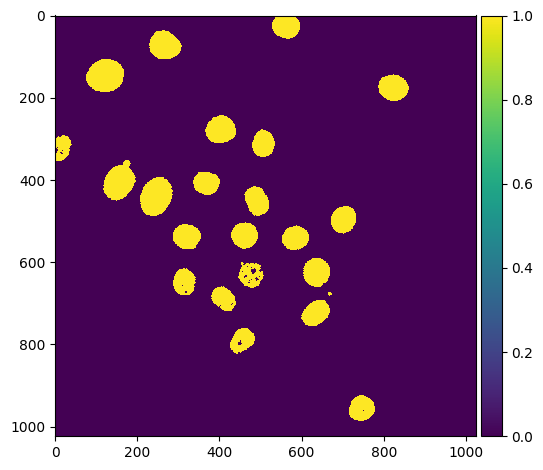

In [217]:
io.imshow(log_preprocessed)

# Jaccard Indices for each Model (Including Indices for Preprocessed ones)

In [35]:
nb_test_index = compute_jaccard_index_for_matches(test_image, nb_prediction)

In [36]:
nb_preprocessed_index = compute_jaccard_index_for_matches(test_image, nb_preprocessed)

In [37]:
svc_test_index = compute_jaccard_index_for_matches(test_image, svc_prediction)

In [38]:
svc_preprocessed_index = compute_jaccard_index_for_matches(test_image, svc_preprocessed)

In [198]:
log_test_index = compute_jaccard_index_for_matches(test_image, log_prediction)

In [199]:
log_preprocessed_index = compute_jaccard_index_for_matches(test_image, log_preprocessed)

In [200]:
nb_val = nb_test_index[0]
nb_pre_val = nb_preprocessed_index[0]
svc_val = svc_test_index[0]
svc_pre_val = svc_preprocessed_index[0]
log_val = log_test_index[0]
log_pre_val = log_preprocessed_index[0]

In [42]:
print(f"SVC_RBF(Without preprocessing):{svc_val} \nSVC_RBF(Preprocessed): {svc_pre_val}")

SVC(Without preprocessing):0.9075975441294827 
SVC(Preprocessed): 0.9149876141764305


In [43]:
print(f"NB(Without preprocessing):{nb_val} \nNB(Preprocessed): {nb_pre_val}")

NB(Without preprocessing):0.9133094066295322 
NB(Preprocessed): 0.8816634470497462


In [202]:
print(f"LOG(Without preprocessing):{log_val} \nLOG(Preprocessed): {log_pre_val}")

LOG(Without preprocessing):0.9052938488280993 
LOG(Preprocessed): 0.9154380733178071


# Saving Models

In [209]:
import pickle

# Load pickled data from file
def save_model(model, model_name):
    with open(f'{model_name}.pkl', 'wb') as f:
        pickle.dump(model, f)

In [210]:
save_model(svc, "SVC_R")

In [211]:
save_model(n_bayes, "N_BAYES")

In [213]:
save_model(logistic_reg, "LOG")

In [44]:
from tqdm import tqdm

In [153]:
def create_test_inferences(model, model_name, resize_shape=(256,256), window_size=5, postprocess=False):
    pdir_name = os.path.join(BASE_PATH, "test-datasets", "Fluo-N2DH-GOWT1")
    tracks = glob.glob(os.path.join(pdir_name, "", "0[0-9]"))
    # print(tracks)
    with tqdm(total=len(tracks)) as pbar:
        for track_number in tracks:
            # print(track_number)
            dir_name = os.path.join(pdir_name, f"{track_number}_{model_name}", "")
            if not os.path.exists(dir_name):
                os.mkdir(dir_name)
            test_img_names = glob.glob(os.path.join(pdir_name, track_number, "*.tif"))
            
            # pbar.write(f"Working on {model_name} -- {track_number[-2:]}")
            for test_img_name in test_img_names:
                # print(test_img_name)
                test_img_path = os.path.join(pdir_name, track_number, test_img_name)
                test_img = io.imread(test_img_path)
                test_img_features, shape = getImgFeatures(test_img_path, window_size=window_size)
                predicted = model.predict(test_img_features).reshape(shape)
                if postprocess:
                    predicted = process(predicted)
                saving_path = os.path.join(dir_name, f"mask{test_img_name[-7:-4]}.tif")
                io.imsave(saving_path, predicted, check_contrast=False)
            pbar.update(1)
        # print(test_img_names)

In [189]:
# create_test_inferences(svc, "SVC_R", window_size=3, postprocess=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [05:56<00:00, 178.24s/it]


In [154]:
# create_test_inferences(n_bayes, "N_BAYES", window_size=3, postprocess=False)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.49it/s]


In [214]:
create_test_inferences(logistic_reg, "LOG", window_size=3, postprocess=True)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.19it/s]


# Traditional ML Testing part

In [191]:
img_num = "077"
track = '02'
model = 'N_BAYES'

In [220]:
def displayResults(model, img_num, track):
    img = io.imread(f"./test-datasets/Fluo-N2DH-GOWT1/{track}/t{img_num}.tif")
    ground_truth = io.imread(f"./test-datasets/Fluo-N2DH-GOWT1/{track}_GT/SEG/man_seg{img_num}.tif") > 0
    predicted = io.imread(f"./test-datasets/Fluo-N2DH-GOWT1/{track}_{model}/mask{img_num}.tif")
    names = {
        'N_BAYES' : "Naive Bayes",
        'SVC_L' : "Support Vector Machine (Linear)",
        'SVC_R' : "Support Vector Machine (RBF)",
        'LOG' : "Logistic Regression"
    }
    fig, ax = plt.subplots(1,3, figsize=[20,15])
    ax[0].imshow(img, cmap='gray')
    ax[0].axis("off")
    ax[0].set(title=f"Cell Image (Track_{track} : {img_num})")
    ax[1].imshow(ground_truth, cmap='gray')
    ax[1].axis('off')
    ax[1].set(title='Ground Truth (Silver Truth)')
    ax[2].imshow(predicted, cmap='gray')
    ax[2].axis('off')
    ax[2].set(title=f'Predicted ({names[model]})');

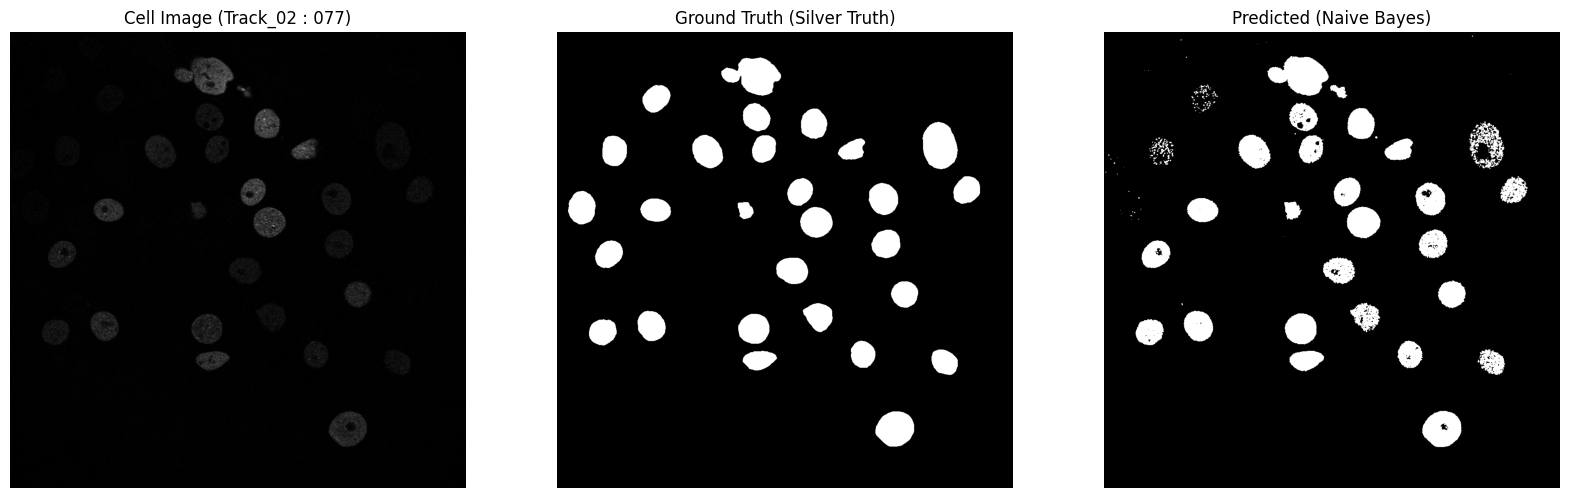

In [221]:
displayResults(model, img_num, track)

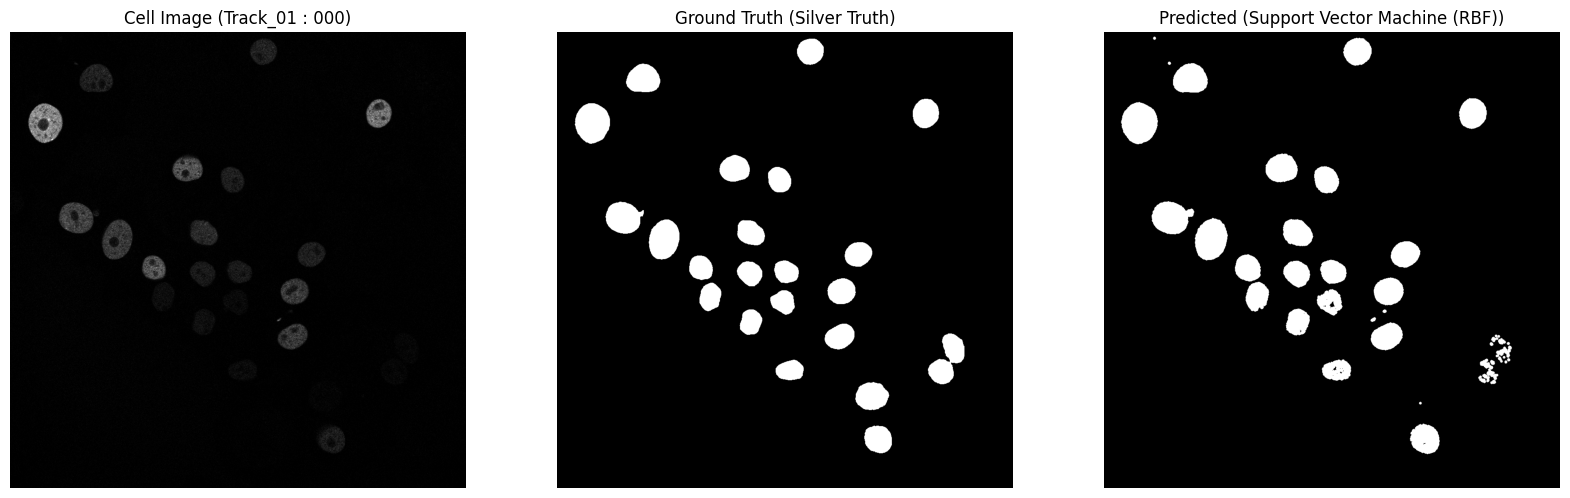

In [222]:
displayResults("SVC_R", , "01")

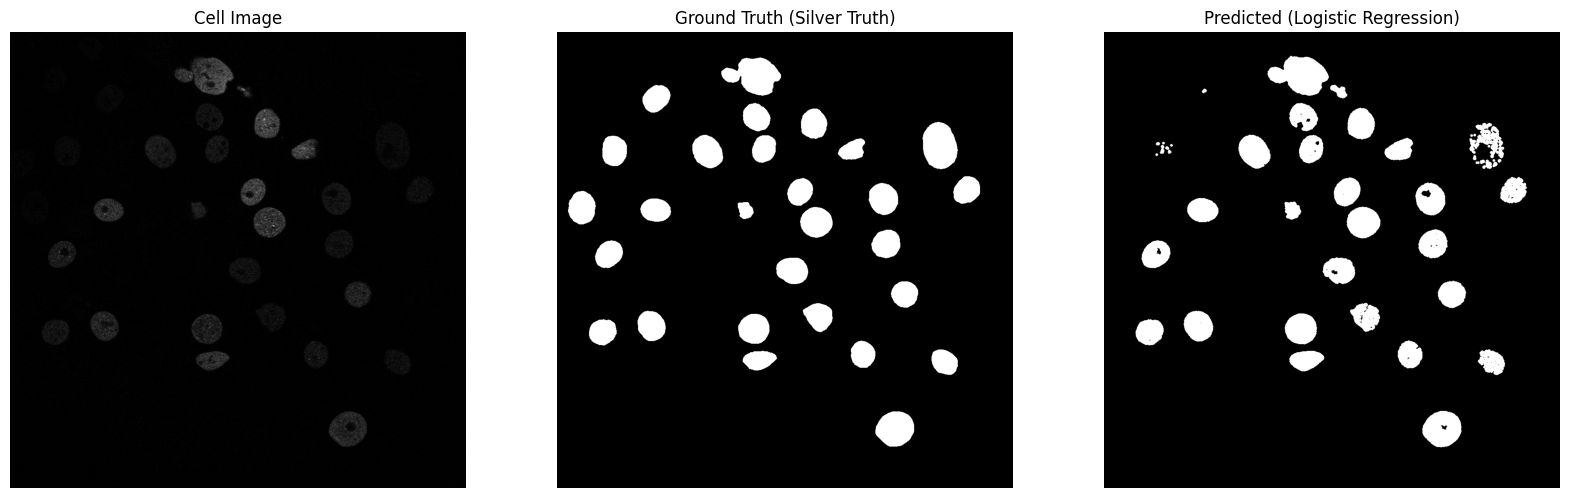

In [215]:
displayResults("LOG", img_num, track)

# Segmentation using Deep Learning

Starting here, you'll see how deep learning can be used to segmenet cell images

In [ ]:
#TODO: Implement Dataloader class, ConvNet  

# Results

Use the snippets below to create a table of results.
When grading, I will look at this table to see if it is consistent with what the numbers should-be and if it is complete.


In [ ]:
import pandas as pd
import numpy as np

# Define methods as columns -- customize if you add more
methods = ['Naive Bayes', 'LogReg', 'SVM(Linear)', 'SVM(RbF)', 'Net (v1)', 'CNN']

# Define the variations heirarchically -- customize if you want to
# add other variations or other datasets from the contest site
datasets = {
    'Fluo-N2DH-GOWT1': {
        'ST': {'01', '02'},
        'GT': {'01', '02'}
    }
}

# Creating MultiIndex for rows
rows = []
for dataset, subsets in datasets.items():
    for subset, tracks in subsets.items():
        for track in tracks:
            rows.append((dataset, subset, track))

# Creating the DataFrame
multi_index = pd.MultiIndex.from_tuples(rows, names=['Dataset', 'Truth', 'Track'])
df = pd.DataFrame(index=multi_index, columns=methods).astype(float)


In [ ]:
# Set the mIoU score for an experiment
df.loc[('Fluo-N2DH-GOWT1', 'GT', '01'), 'Naive Bayes'] = 0.00 # Whatever you get

# Display the updated DataFrame
display(df)


Naive Bayes  LogReg  SVM(Linear)  SVM(RbF)  \
Dataset         Truth Track                                               
Fluo-N2DH-GOWT1 ST    01             NaN     NaN          NaN       NaN   
                      02             NaN     NaN          NaN       NaN   
                GT    01             0.0     NaN          NaN       NaN   
                      02             NaN     NaN          NaN       NaN   

                             Net (v1)  CNN  
Dataset         Truth Track                 
Fluo-N2DH-GOWT1 ST    01          NaN  NaN  
                      02          NaN  NaN  
                GT    01          NaN  NaN  
                      02          NaN  NaN

# Submission

1.  Your solution should be contained within one notebook, with plenty of visualizations.
3.  Download your soution as a .ipynb file
4.  Use [my nbconvert notebook](https://colab.research.google.com/drive/13GvgiBl_jbGi3OSFbGAofmUBbh8yhOht#scrollTo=hiz8-EeUw95e) to create a PDF or docx to submit.